In [1]:
import pykalman

import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
%matplotlib inline
import seaborn as sns

import sys,os,pdb,copy,pickle,itertools
from importlib import reload
import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp
import database
db = database.db

import change_point_analysis as cpa
import change_point_plot as cpp

import data_prep_new as dpn
import preprocess as prep
import animate_helper as ah
np.set_printoptions(precision=3,suppress=True)

In [2]:
data_dir_full = db.query('owner=="ipshita"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][0]

In [3]:
# data_dir_full = '/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/'
data_dir_full = db.query('owner=="ipshita"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][0] #0

# load data
mat_to_return=prep.load_stuff(data_dir_full,sessionPulses='*SessionPulses.Events.mat')
sessionPulses=mat_to_return['sessionPulses']
# filtered = mat_to_return['filtered']
# behavior=mat_to_return['behavior']
# ripples = mat_to_return['ripples']
# cell_metrics = mat_to_return['cell_metrics']

prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=True,extra_load={'sessionPulses':'*SessionPulses.Events.mat'},
                               load_type='ipshita'
                              )
spk_beh_df=prep_res['spk_beh_df']
_,spk_beh_df = dpp.group_into_trialtype(spk_beh_df)
cell_cols_d = prep_res['cell_cols_d']
beh_df = prep_res['beh_df']
beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
spike_trains = prep_res['spike_trains']

# import nmf_one_session as nos
# from itertools import product
# reload(nos)
# condition_df = {'do_normalize':[True,False],'speed_thresh':[0,1,5],'israte':[True,False]}
# condition_df = pd.DataFrame(list(product(*condition_df.values())),columns=list(condition_df.keys()))
# n_compo = 4
# nmf_res_d = {}

# for _,combo in condition_df.iterrows():
#     do_normalize,speed_thresh,israte = combo['do_normalize'],combo['speed_thresh'],combo['israte']
#     res_to_save_name = f'nmf_{n_compo}_normalize_{do_normalize}_speedthresh_{int(speed_thresh)}_rate_{israte}'
#     nmf_res_d[tuple(combo.values)]=nos.nmf_one_session(data_dir_full,kwargs_={'n_compo':n_compo,'doplots':False,'n_clust':6,'do_normalize':do_normalize,'force_reload':False,'dosave':False,'speed_thresh':speed_thresh,'res_to_save_name':res_to_save_name,'israte':israte})




/mnt/home/szheng/ceph/ad/ipshita_data/CA3_mEC/IZ33/IZ33_580um_210312_sess8/py_data/spk_beh_df.p saved!


In [4]:
# get place fields!!!!
import place_field_analysis as pf
reload(pf)

# cell_cols_d = get_cell_cols_d_with_brainregion(cell_metrics)
br = 'CA1'
ct=  'pyr'#'pyr'#'int'#
cell_cols = cell_cols_d[br,ct]
# cell_cols = np.concatenate([cell_cols_d[br,'pyr'],cell_cols_d[br,'int']])
# cell_cols = cell_cols_d['pyr']

nbins = int(np.ceil(spk_beh_df['lin'].max() / 222 * 100))

spk_beh_df,_ = dpp.add_lin_binned(spk_beh_df,nbins=nbins)
# _,spk_beh_df=dpp.group_into_trialtype(spk_beh_df,additional_groupers=['stim'])
_,spk_beh_df=dpp.group_into_trialtype(spk_beh_df,additional_groupers=None)
fr_map_d,count_d,occu_d = pf.ratemap_from_spk_beh_df_alltrialtype(spk_beh_df,cell_cols,speed_thresh=1.,nbins=nbins,smth_in_bin=2.5)
fr_map_d_concat = pd.concat(fr_map_d)

# get fields
fr_map_peaks_d = {}
field_res_d = {}
min_rate=0.6
for key in fr_map_d.keys():

    fr_map = fr_map_d[key]
    count = count_d[key]
    occu = occu_d[key]
    field_res_d[key] =pf.get_field_peaks_one_trialtype(fr_map,count,occu,min_rate=min_rate)
    


In [5]:

fr_map_dict=pa.get_fr_map_trial(spk_beh_df,cell_cols,trialtype_key='trial_type',speed_thresh=1.,order=['smooth','divide'],n_lin_bins=nbins,speed_key='speed')
fr_map_trial_d = {k:val[0] for k,val in fr_map_dict.items()}
fr_map_trial_df_d=pd.concat({k:pf.fr_map_trial_to_df(fr_map_trial_d[k],cell_cols) for k in fr_map_dict.keys()},axis=0)


cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe


In [6]:
spk_beh_df_onetask = spk_beh_df.query('task_index==0')
fr_map_trial_all,_,_=pa.get_fr_map_trial_onegroup(spk_beh_df_onetask,cell_cols,gauss_width=2.5,order=['smooth','divide'],n_lin_bins=nbins,speed_key='speed')

fr_map_trial_all_df = pf.fr_map_trial_to_df(fr_map_trial_all,cell_cols)


cant format into a dataframe


# sim data

In [7]:
import pca_analysis as pcaa
reload(pcaa)

<module 'pca_analysis' from '/mnt/home/szheng/projects/nmf_analysis/pca_analysis.py'>

In [9]:
task_ind,tt_ind = 0,1
fr_map_trial_original=fr_map_trial_d[task_ind,tt_ind]
fr_map_trial_mean = fr_map_trial_original.mean(axis=(-1))
fr_map_trial_sim = fr_map_trial_mean[:,:,None] * (1+np.arange(fr_map_trial_original.shape[-1])) / (fr_map_trial_original.shape[-1] / 1.5)

task_ind,tt_ind = 0,1
fr_map_trial = fr_map_trial_sim#fr_map_trial_d[task_ind,tt_ind]#fr_map_trial_all#
reload(pcaa)
fr_map_trial_centered_normed_df,fr_map_trial_centered_normed = pcaa.preprocess_fr_map_trial(fr_map_trial,cell_cols)
X_l=pcaa.prep_X_l(fr_map_trial_centered_normed)

In [11]:
%%time
#high lam
reload(pcaa)
w_l_allfac_fit_highlam, h_l_allfac_fit_highlam,l_all_allfac, l_recon_allfac, l_reg_allfac,w_l_allfac, h_l_allfac,r2_allfac, r2_pos_allfac  = \
    pcaa.train_all_factor(X_l,n_fac=1,lam=1000.,max_iters = 800, stop_thresh = 0.00001,
                    fr_map_trial_centered_normed_df=fr_map_trial_centered_normed_df,w_l_allfac=None,h_l_allfac=None,
                    pos_mask = None,return_init=True)

CPU times: user 5.93 s, sys: 3.69 s, total: 9.62 s
Wall time: 2.68 s


In [12]:
import vbpca

In [22]:
fr_map_trial

array([[[ 0.105,  0.209,  0.314, ...,  1.885,  1.99 ,  2.095],
        [ 0.1  ,  0.199,  0.299, ...,  1.793,  1.893,  1.993],
        [ 0.092,  0.184,  0.276, ...,  1.656,  1.749,  1.841],
        ...,
        [ 0.286,  0.573,  0.859, ...,  5.156,  5.442,  5.729],
        [ 0.248,  0.496,  0.744, ...,  4.465,  4.713,  4.962],
        [ 0.224,  0.449,  0.673, ...,  4.039,  4.264,  4.488]],

       [[ 0.045,  0.09 ,  0.134, ...,  0.806,  0.85 ,  0.895],
        [ 0.052,  0.103,  0.155, ...,  0.929,  0.98 ,  1.032],
        [ 0.062,  0.123,  0.185, ...,  1.109,  1.171,  1.233],
        ...,
        [ 0.238,  0.476,  0.714, ...,  4.286,  4.524,  4.762],
        [ 0.22 ,  0.439,  0.659, ...,  3.951,  4.171,  4.39 ],
        [ 0.208,  0.417,  0.625, ...,  3.752,  3.961,  4.169]],

       [[ 0.047,  0.094,  0.14 , ...,  0.842,  0.889,  0.936],
        [ 0.058,  0.115,  0.173, ...,  1.038,  1.095,  1.153],
        [ 0.076,  0.153,  0.229, ...,  1.375,  1.451,  1.527],
        ...,
        [ 0.

In [109]:
reload(vbpca)
X_resid,X_mean = vbpca.preprocess(fr_map_trial,center_axis=0, residual_axis=-1, do_normalize=True,)

In [111]:
1. * False

0.0

<IPython.core.display.Javascript object>


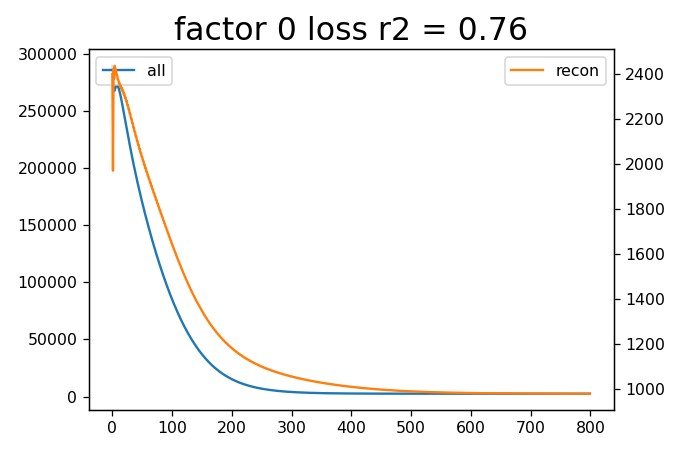

(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:title={'center':'factor 0 loss r2 = 0.76'}>)

In [78]:
import vbpca_plot as vp
reload(vp)
vp.plot_loss(l_all_allfac,l_recon_allfac,r2_allfac)

In [79]:
# post process
# trial_ind_l=spk_beh_df_onetask['trial'].unique()
trial_ind_l=spk_beh_df_onetask.query('visitedArm==@tt_ind')['trial'].unique()

stim_per_trial = spk_beh_df_onetask.groupby('trial')['stim'].unique().apply(lambda x:x[0])
visitedArm_per_trial = spk_beh_df_onetask.groupby('trial')['visitedArm'].unique().apply(lambda x:x[0])
random_per_trial = pd.Series(np.random.randint(2,size=stim_per_trial.shape[0]))

h_l_allfac_fit_df = pcaa.post_process_loadings(h_l_allfac_fit_highlam,trial_ind_l=trial_ind_l)
h_l_allfac_fit_df['stim'] = stim_per_trial.loc[h_l_allfac_fit_df['trial'].values].values
h_l_allfac_fit_df['visitedArm'] = visitedArm_per_trial.loc[h_l_allfac_fit_df['trial'].values].values
h_l_allfac_fit_df['random'] = random_per_trial.loc[h_l_allfac_fit_df['trial'].values].values

trial_l = np.arange(h_l_allfac_fit_highlam.shape[-1])
color_l = ah.map_colors(trial_l,npos=None,cmap_name='vlag')
color_l_series = pd.Series(color_l,index=trial_ind_l)

stim_per_trial_actual = stim_per_trial.loc[trial_ind_l]
linestyle_l = ['-.' if i else '-' for i in stim_per_trial_actual] 

In [26]:
# plot

In [82]:
import nnls
from nnls import nnlsm_activeset

In [105]:
A = h_l_allfac_fit_highlam[0,[0],:].T
B = X_l[0,:,:].T

In [106]:
B.shape

(20, 100)

In [99]:
B

array([[ 0.172],
       [ 0.154],
       [ 0.136],
       [ 0.118],
       [ 0.1  ],
       [ 0.082],
       [ 0.064],
       [ 0.045],
       [ 0.027],
       [ 0.009],
       [-0.009],
       [-0.027],
       [-0.045],
       [-0.064],
       [-0.082],
       [-0.1  ],
       [-0.118],
       [-0.136],
       [-0.154],
       [-0.172]])

In [121]:
!pip install osqp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.2/298.2 kB 3.4 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.6 MB/s eta 0:00:00:00:0100:01


In [110]:
w_l_allfac_fit_highlam[0]

array([[ 0.089],
       [-0.108],
       [ 0.017],
       [-0.152],
       [ 0.065],
       [-0.05 ],
       [ 0.165],
       [-0.092],
       [ 0.219],
       [-0.173],
       [ 0.23 ],
       [-0.007],
       [-0.113],
       [ 0.033],
       [-0.022],
       [-0.034],
       [-0.019],
       [-0.072],
       [-0.145],
       [ 0.009],
       [ 0.004],
       [-0.033],
       [-0.031],
       [ 0.038],
       [-0.006],
       [-0.004],
       [ 0.114],
       [ 0.003],
       [-0.06 ],
       [ 0.185],
       [ 0.003],
       [ 0.069],
       [ 0.041],
       [ 0.041],
       [ 0.071],
       [ 0.018],
       [ 0.125],
       [ 0.013],
       [ 0.129],
       [ 0.017],
       [ 0.065],
       [ 0.224],
       [ 0.02 ],
       [ 0.099],
       [ 0.001],
       [ 0.013],
       [ 0.051],
       [ 0.244],
       [ 0.026],
       [-0.053],
       [-0.056],
       [-0.102],
       [ 0.061],
       [ 0.193],
       [-0.059],
       [-0.015],
       [ 0.199],
       [ 0.014],
       [ 0.053

In [111]:

w_solved=nnlsm_activeset(A,B)[0]

In [117]:
w_solved

array([[0.   , 0.   , 0.   , 0.   , 0.004, 0.   , 0.135, 0.   , 0.046,
        0.   , 0.262, 0.   , 0.   , 0.   , 0.   , 0.032, 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.027, 0.085, 0.   , 0.   , 0.255,
        0.   , 0.   , 0.22 , 0.   , 0.073, 0.007, 0.054, 0.272, 0.   ,
        0.047, 0.006, 0.078, 0.025, 0.   , 0.109, 0.   , 0.201, 0.   ,
        0.   , 0.04 , 0.446, 0.022, 0.   , 0.   , 0.   , 0.   , 0.074,
        0.   , 0.   , 0.034, 0.034, 0.   , 0.   , 0.101, 0.   , 0.132,
        0.   , 0.014, 0.   , 0.052, 0.   , 0.   , 0.   , 0.046, 0.051,
        0.035, 0.   , 0.146, 0.   , 0.   , 0.   , 0.106, 0.   , 0.029,
        0.087, 0.148, 0.198, 0.   , 0.284, 0.   , 0.062, 0.09 , 0.   ,
        0.437, 0.   , 0.081, 0.   , 0.   , 0.029, 0.   , 0.   , 0.444,
        0.   ]])

<IPython.core.display.Javascript object>


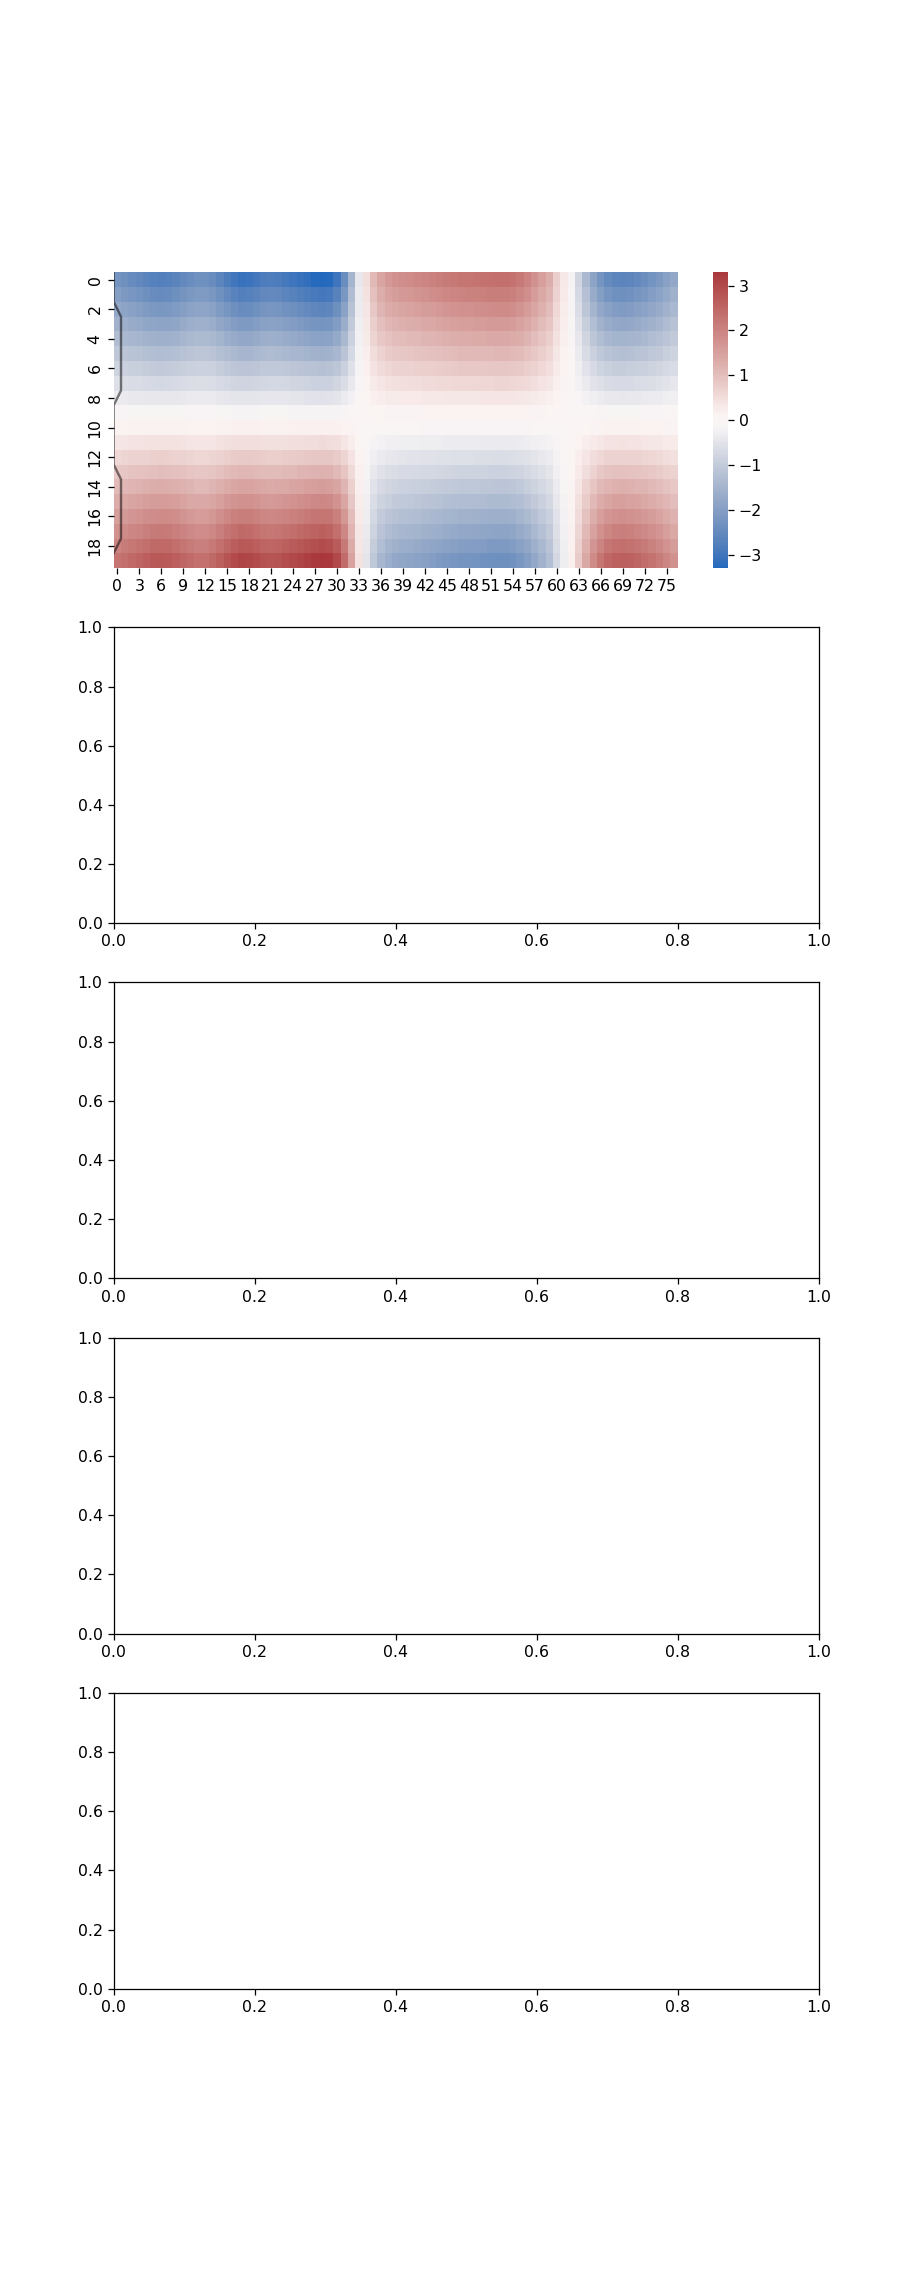

NameError: name 'lin_val_left' is not defined

In [80]:
%matplotlib notebook
# toplot = h_l_allfac_fit_df.query('trial<=33')
toplot = h_l_allfac_fit_df.query('visitedArm==@tt_ind')
# toplot = h_one_trial_df_l.query('25>=trial>=15')
n_fac = 5#h_l_allfac_fit.shape[1]
nplots = n_fac
fig,axs=plt.subplots(nplots,1,figsize=(1*8,nplots*4))
cols = h_l_allfac_fit_df.columns[:nplots]
for ii in range(n_fac):
#     sns.lineplot(data=toplot,x='pos',y=f'pc{ii}',hue='stim',palette='coolwarm',ax=axs[ii])
#     sns.lineplot(data=toplot,x='pos',y=f'pc{ii}',hue='random',palette='coolwarm',ax=axs[ii])
    ax=sns.heatmap(h_l_allfac_fit_highlam[:,ii,:].T,cmap='vlag',ax=axs[ii])
    ax.plot(stim_per_trial_actual.values,np.arange(len(stim_per_trial_actual)),c='k',alpha=0.5)
    ph.plot_vlines(lin_val_left/binsize_in_lin,ax=axs[ii],fig=fig)
plt.tight_layout()